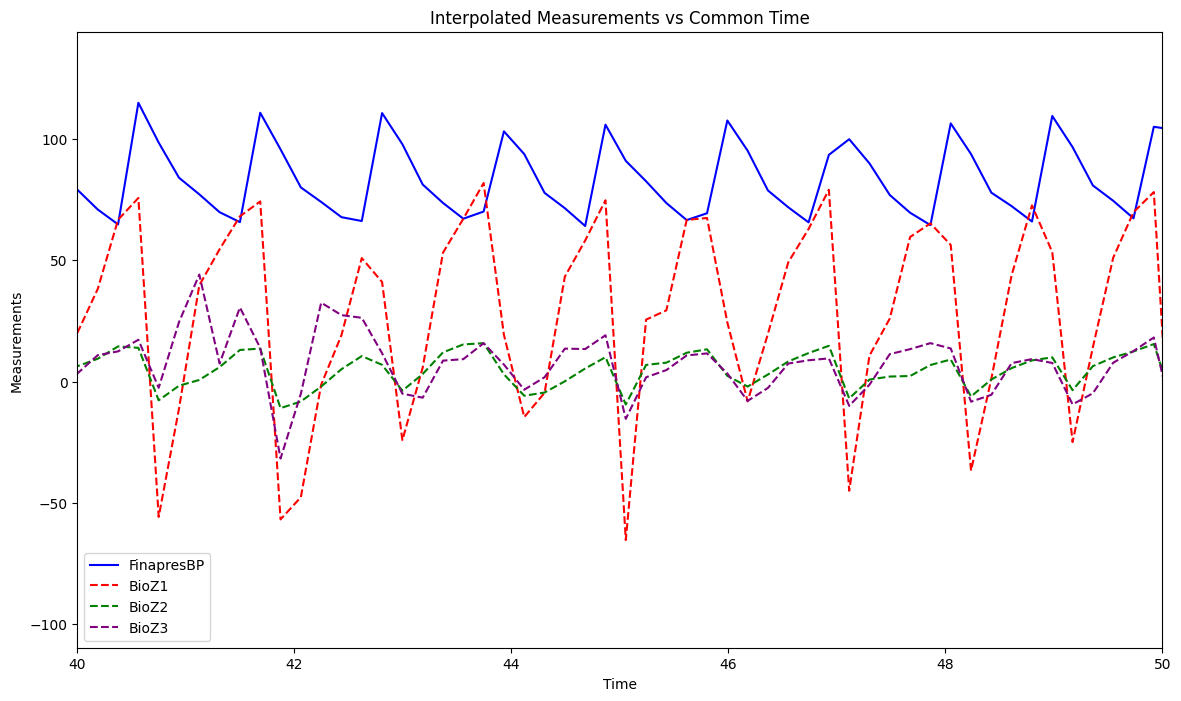

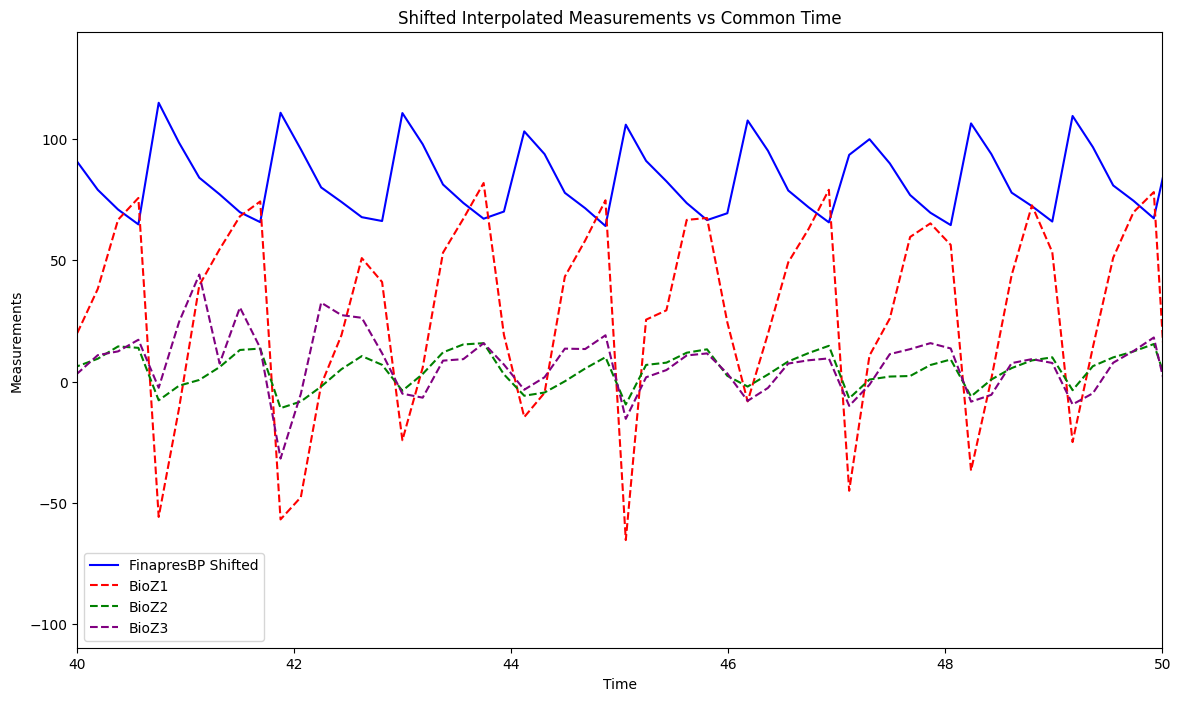

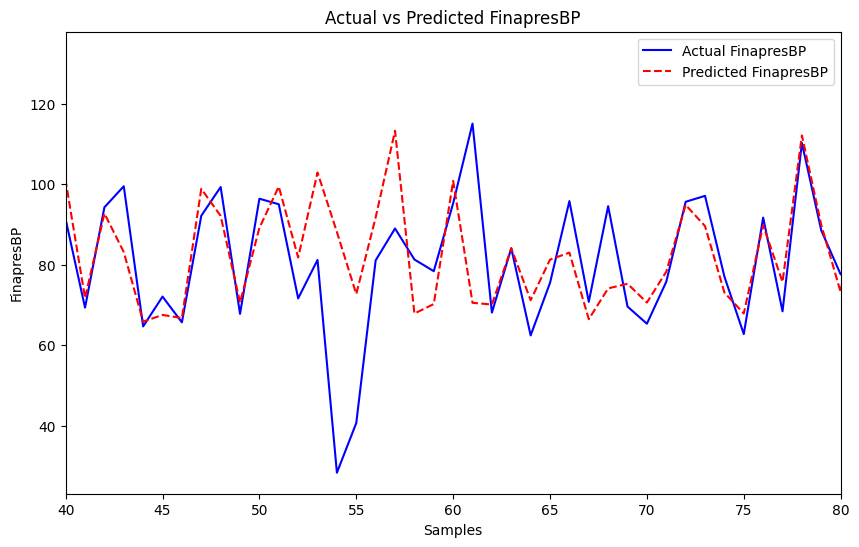

Mean Absolute Error: 8.466985183595678
Root Mean Squared Error: 13.24178497704087
R^2 Score: 0.4151793123464209


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load and inspect the data
data_path = '../../data/data_trial1_finapresBP_all.csv'  # Update this path
data = pd.read_csv(data_path)

# Interpolate data onto a common time axis.  This is because we have different sampling rates for the Finapress and the the Bioimpedance
start_time = max(min(data['time']), min(data['time.1']))
end_time = min(max(data['time']), max(data['time.1']))
common_time = np.linspace(start_time, end_time, num=1000)

finapres_interpolator = interp1d(data['time'], data['FinapresBP'], bounds_error=False, fill_value="extrapolate")
bioz1_interpolator = interp1d(data['time.1'], data['BioZ1'], bounds_error=False, fill_value="extrapolate")
bioz2_interpolator = interp1d(data['time.1'], data['BioZ2'], bounds_error=False, fill_value="extrapolate")
bioz3_interpolator = interp1d(data['time.1'], data['BioZ3'], bounds_error=False, fill_value="extrapolate")

finapres_common = finapres_interpolator(common_time)
bioz1_common = bioz1_interpolator(common_time)
bioz2_common = bioz2_interpolator(common_time)
bioz3_common = bioz3_interpolator(common_time)


# Plotting - take a look at what we have
plt.figure(figsize=(14, 8))

# FinapresBP
plt.plot(common_time, finapres_common, label='FinapresBP', color='blue')

# BioZ Measurements
plt.plot(common_time, bioz1_common, label='BioZ1', linestyle='--', color='red')
plt.plot(common_time, bioz2_common, label='BioZ2', linestyle='--', color='green')
plt.plot(common_time, bioz3_common, label='BioZ3', linestyle='--', color='purple')

plt.xlabel('Time')
plt.ylabel('Measurements')
plt.title('Interpolated Measurements vs Common Time')
plt.legend()

# Setting the x-axis limits to zoom in to the period of 40-50 seconds
plt.xlim(40, 50)

plt.show()
# So far this is looking good. I think these are correctly aligned and I believe the time stamps were correct and that this new common time bectyor is good

# If you look at the plots it is clear there is a lag between the Finapress peaks and the bioimpedance peaks. This is because the finapress works at the finger
# tip and therefore it takes longer for the pulse of blood to arrive there. This lag is making our problem more nonlinear than it needs to be. It might be nice
# to shift say the Finapress signal by some amount of time so that its peaks line up better with the peaks of the bioimpedance signals? You might even while you are at it, invent the bioimpedance signals?
# Here I will just shift it by 250 ms which is just an eye balled amount. How might you calculate a better shift?
# So assuming I want to shift by 250ms I need to calculated how many data points that is. So we calculate the average time difference between points (assuming even sampling)
time_difference = np.diff(common_time)
average_delta_time = np.mean(time_difference)

# Calculate how many indices correspond to a 0.25 second shift
shift_indices = int(0.25 / average_delta_time)

# Shift the FinapresBP measurements
finapres_shifted = np.roll(finapres_common, shift_indices)
#finapres_shifted[-shift_indices:] = 0  # You might need to padd the end with 0 to maintain array length or just truncate the vectors

# Plotting for comparison to see what it now looks like
# Plotting
plt.figure(figsize=(14, 8))

# FinapresBP
plt.plot(common_time, finapres_shifted, label='FinapresBP Shifted', color='blue')

# BioZ Measurements
plt.plot(common_time, bioz1_common, label='BioZ1', linestyle='--', color='red')
plt.plot(common_time, bioz2_common, label='BioZ2', linestyle='--', color='green')
plt.plot(common_time, bioz3_common, label='BioZ3', linestyle='--', color='purple')

plt.xlabel('Time')
plt.ylabel('Measurements')
plt.title('Shifted Interpolated Measurements vs Common Time')
plt.legend()

# Setting the x-axis limits to zoom in to the period of 40-50 seconds
plt.xlim(40, 50)

plt.show()
# This looks good


# Now lets try some regression:  prepare dataset for machine learning model
features = np.vstack((bioz1_common, bioz2_common, bioz3_common)).T
target = finapres_shifted

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Step 5: Initialize, train, and evaluate the regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Plotting actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual FinapresBP', color='blue')
plt.plot(y_pred, label='Predicted FinapresBP', color='red', linestyle='--')
plt.title('Actual vs Predicted FinapresBP')
plt.xlabel('Samples')
plt.ylabel('FinapresBP')
plt.legend()
# Setting the x-axis limits to zoom in to the period of 40-80 seconds
plt.xlim(40, 80)
plt.show()

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R^2 Score: {r2}')

# Thats not too bad. Try messing with the shift and see what effects it has